In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

In [2]:
coloc_df = pd.read_csv('data/All_Colocalization_Scores.csv')
coloc_df

,Subject_ID,Treatment_Status,Task_1,Task_2,Colocalization_Score
0,1182412B,Treated,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic condition...,15.538054
1,1182412B,Treated,(R)-3-Hydroxybutanoate synthesis,ATP regeneration from glucose (normoxic condit...,4.040988
2,1182412B,Treated,(R)-3-Hydroxybutanoate synthesis,Acetoacetate synthesis,15.538054
3,1182412B,Treated,(R)-3-Hydroxybutanoate synthesis,Alanine synthesis,15.538054
4,1182412B,Treated,ATP generation from glucose (hypoxic condition...,ATP regeneration from glucose (normoxic condit...,4.040988
...,...,...,...,...,...
215,120161,Untreated,ATP generation from glucose (hypoxic condition...,Acetoacetate synthesis,13.973880
216,120161,Untreated,ATP generation from glucose (hypoxic condition...,Alanine synthesis,13.973880
217,120161,Untreated,ATP regeneration from glucose (normoxic condit...,Acetoacetate synthesis,4.346601
218,120161,Untreated,ATP regeneration from glucose (normoxic condit...,Alanine synthesis,4.346601


## LogFC Analysis

In [3]:
df = coloc_df.copy()

pair_group = df.groupby(["Task_1","Task_2","Treatment_Status"])["Colocalization_Score"].mean()
pivot = pair_group.unstack()

T = pivot["Treated"]
U = pivot["Untreated"]

# Signed Log Fold Change
pivot["logFC"] = np.sign(T - U) * np.log2((abs(T) + 1e-6) / (abs(U) + 1e-6))

pivot = pivot.reset_index()
pivot.head()

Treatment_Status,Task_1,Task_2,Treated,Untreated,logFC
0,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic condition...,11.801559,10.679186,0.144176
1,(R)-3-Hydroxybutanoate synthesis,ATP regeneration from glucose (normoxic condit...,3.397062,3.143459,0.111935
2,(R)-3-Hydroxybutanoate synthesis,Acetoacetate synthesis,11.801559,10.679186,0.144176
3,(R)-3-Hydroxybutanoate synthesis,Alanine synthesis,11.801559,10.679186,0.144176
4,ATP generation from glucose (hypoxic condition...,ATP regeneration from glucose (normoxic condit...,3.397062,3.143459,0.111935


/tmp/ipykernel_630399/1263809325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


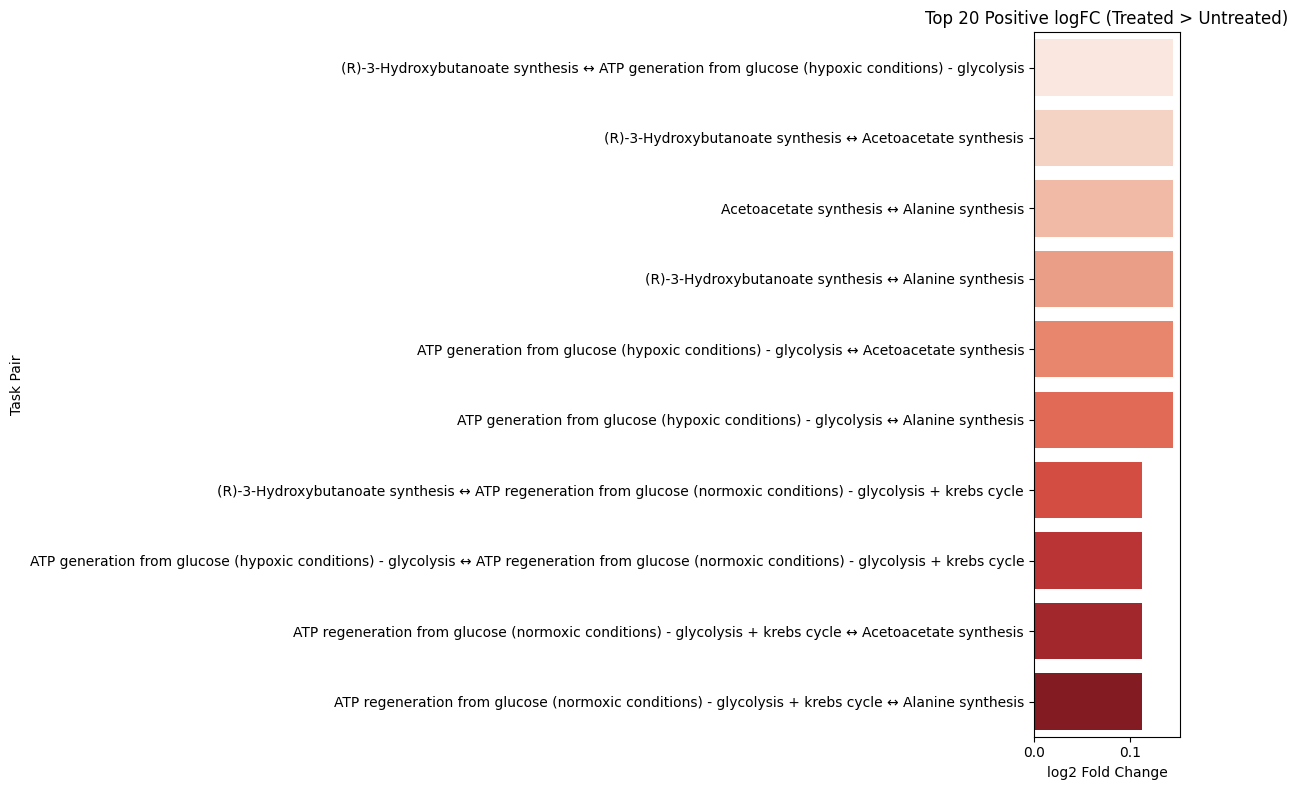

In [4]:
top_up = pivot.sort_values("logFC", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_up,
    y=top_up["Task_1"] + " ↔ " + top_up["Task_2"],
    x="logFC",
    palette="Reds"
)
plt.title("Top 20 Positive logFC (Treated > Untreated)")
plt.xlabel("log2 Fold Change")
plt.ylabel("Task Pair")
plt.tight_layout()
plt.show()


/tmp/ipykernel_557846/3526225491.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


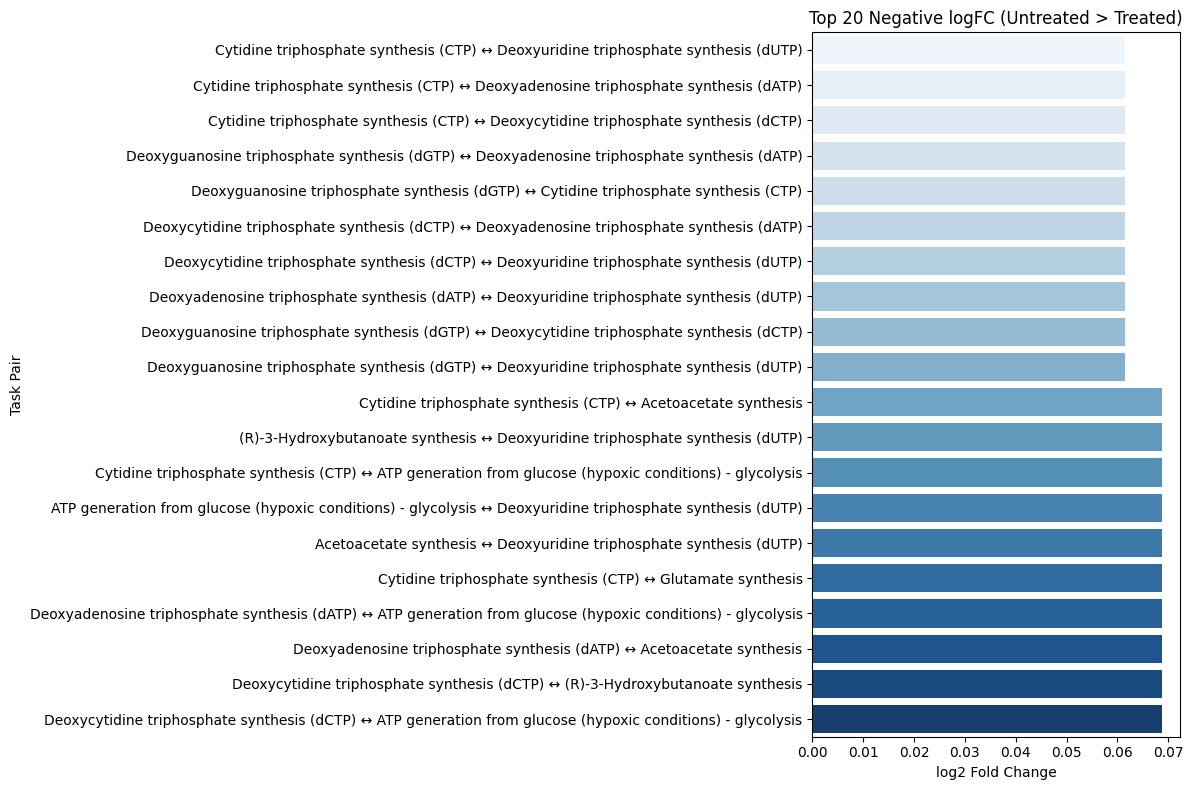

In [32]:
top_down = pivot.sort_values("logFC", ascending=True).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_down,
    y=top_down["Task_1"] + " ↔ " + top_down["Task_2"],
    x="logFC",
    palette="Blues"
)
plt.title("Top 20 Negative logFC (Untreated > Treated)")
plt.xlabel("log2 Fold Change")
plt.ylabel("Task Pair")
plt.tight_layout()
plt.show()


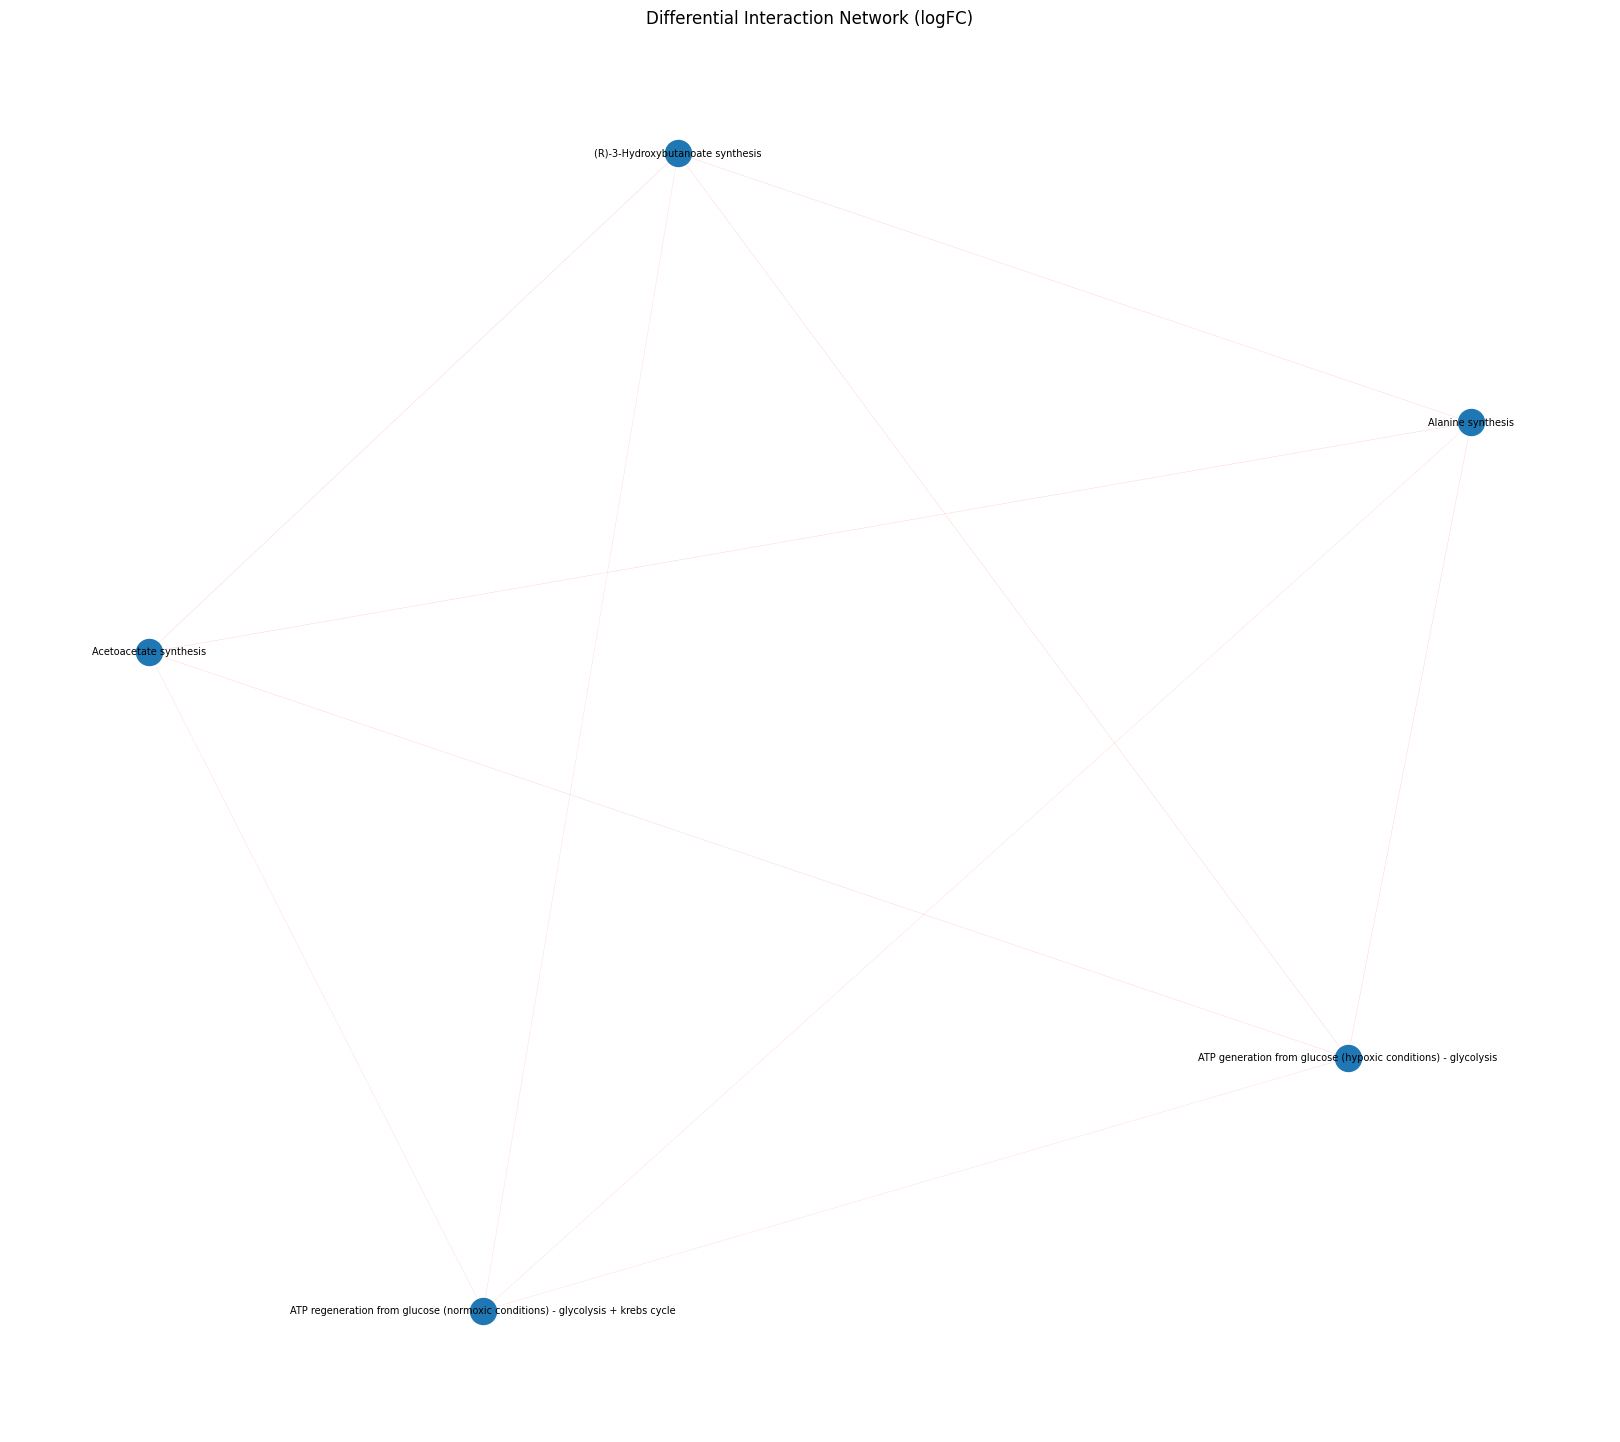

In [5]:
G = nx.Graph()

for _, r in pivot.iterrows():
    t1, t2, v = r["Task_1"], r["Task_2"], r["logFC"]
    if pd.isna(v): 
        continue
    G.add_edge(
        t1, t2,
        weight=abs(v),
        color="red" if v > 0 else "blue"
    )

pos = nx.spring_layout(G, seed=42)

edges = G.edges()
colors = [G[u][v]["color"] for u, v in edges]
weights = [G[u][v]["weight"] for u, v in edges]

plt.figure(figsize=(16, 14))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=350,
    edge_color=colors,
    width=[w * 0.4 for w in weights],
    font_size=7
)
plt.title("Differential Interaction Network (logFC)")
plt.show()


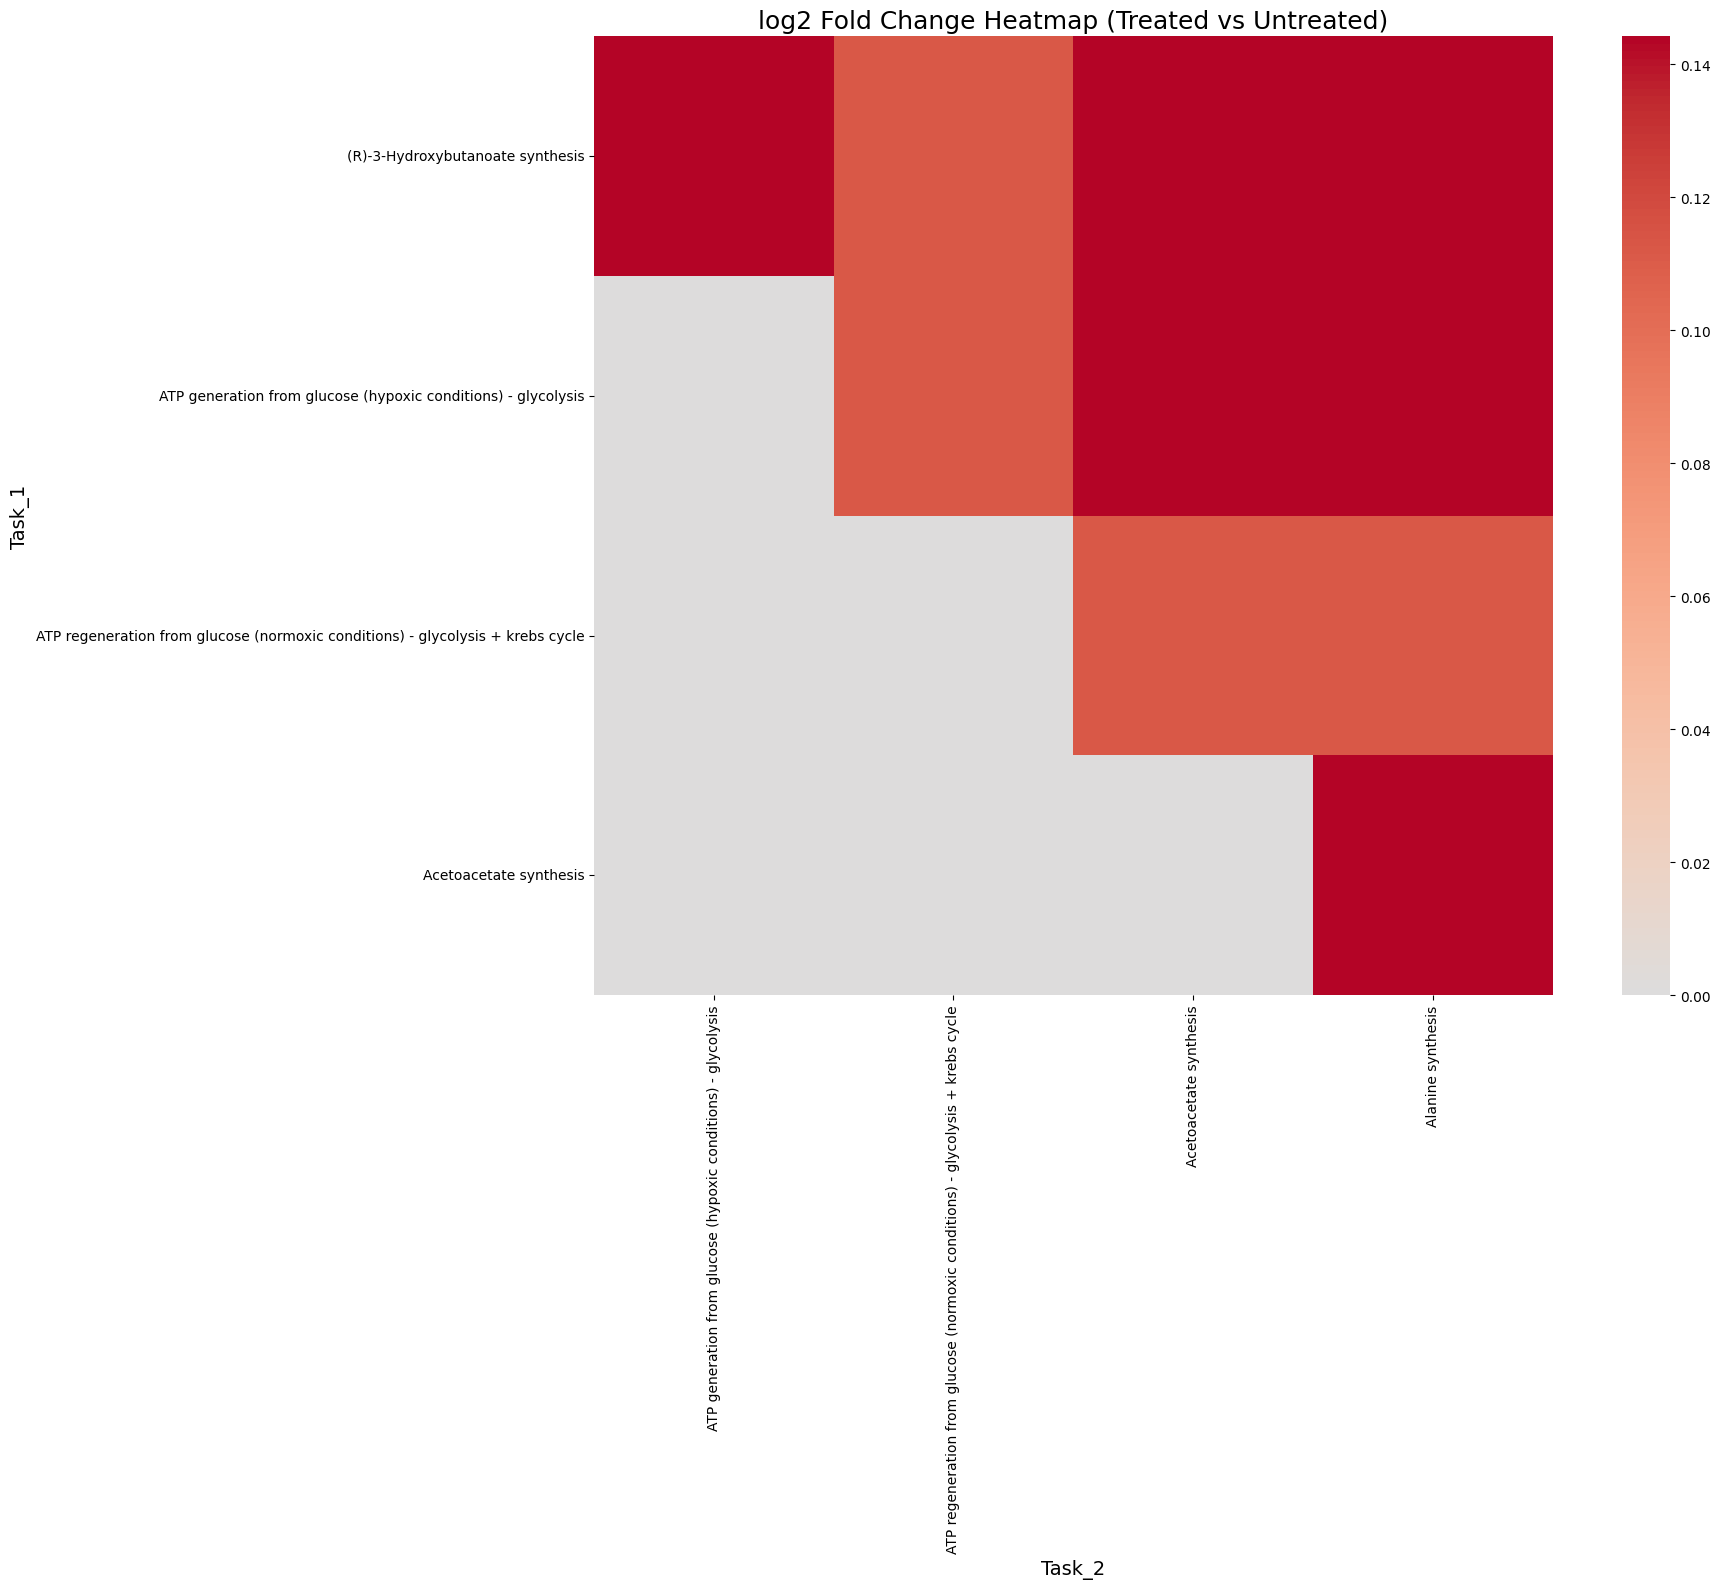

In [6]:
mat_logfc = pivot.pivot(
    index="Task_1",
    columns="Task_2",
    values="logFC"
).fillna(0) 

plt.figure(figsize=(20, 16))
sns.heatmap(
    mat_logfc, 
    cmap="coolwarm", 
    center=0,
    square=True
)
plt.title("log2 Fold Change Heatmap (Treated vs Untreated)", fontsize=18)
plt.xlabel("Task_2", fontsize=14)
plt.ylabel("Task_1", fontsize=14)
plt.tight_layout()
plt.show()
